Purpose:

Predict if credit is "Good" or "Bad"

Business related questions:

- What are some of the features that people with "Good" credit have?
- What is the average age of applicants?
- What is the average amount people have in their checking and savings account?
- What is the most common property type?
- what is the most common sex/status with "Good" credit



In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
df = pd.read_csv('german.data', sep='\s+')
df.head(2)

,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1.1
0,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,2
1,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1


In [9]:
column_names = ['checking_account', 'duration_month', 'credit_history', 'credit_purpose','credit_amount','savings_account','present_employment','disposable_income_percent',
 'status_sex','debtors','residence_since','property','age','other_installments', 'housing','credits_at_current_bank','job','dependants','telephone', 'foreign_worker','class']

In [10]:
df.columns = column_names
df.head(2)

,checking_account,duration_month,credit_history,credit_purpose,credit_amount,savings_account,present_employment,disposable_income_percent,status_sex,debtors,...,property,age,other_installments,housing,credits_at_current_bank,job,dependants,telephone,foreign_worker,class
0,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,2
1,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   checking_account           999 non-null    object
 1   duration_month             999 non-null    int64 
 2   credit_history             999 non-null    object
 3   credit_purpose             999 non-null    object
 4   credit_amount              999 non-null    int64 
 5   savings_account            999 non-null    object
 6   present_employment         999 non-null    object
 7   disposable_income_percent  999 non-null    int64 
 8   status_sex                 999 non-null    object
 9   debtors                    999 non-null    object
 10  residence_since            999 non-null    int64 
 11  property                   999 non-null    object
 12  age                        999 non-null    int64 
 13  other_installments         999 non-null    object
 14  housing   

In [12]:
df.describe()

,duration_month,credit_amount,disposable_income_percent,residence_since,age,credits_at_current_bank,dependants,class
count,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000
mean,20.917918,3273.362362,2.971972,2.843844,35.514515,1.406406,1.155155,1.300300
std,12.055619,2823.365811,1.118802,1.103665,11.337487,0.577639,0.362234,0.458618
min,4.000000,250.000000,1.000000,1.000000,19.000000,1.000000,1.000000,1.000000
25%,12.000000,1368.500000,2.000000,2.000000,27.000000,1.000000,1.000000,1.000000
50%,18.000000,2320.000000,3.000000,3.000000,33.000000,1.000000,1.000000,1.000000
75%,24.000000,3972.500000,4.000000,4.000000,42.000000,2.000000,1.000000,2.000000
max,72.000000,18424.000000,4.000000,4.000000,75.000000,4.000000,2.000000,2.000000


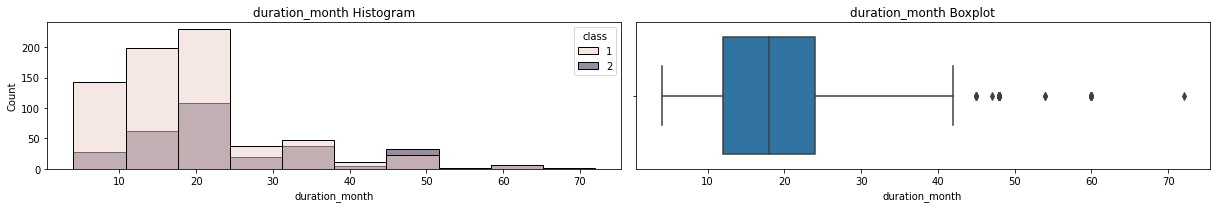

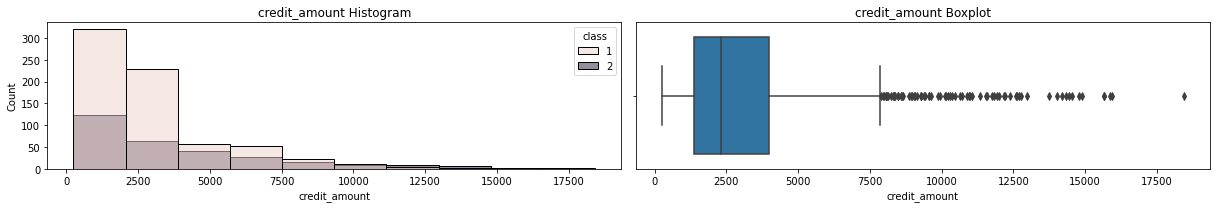

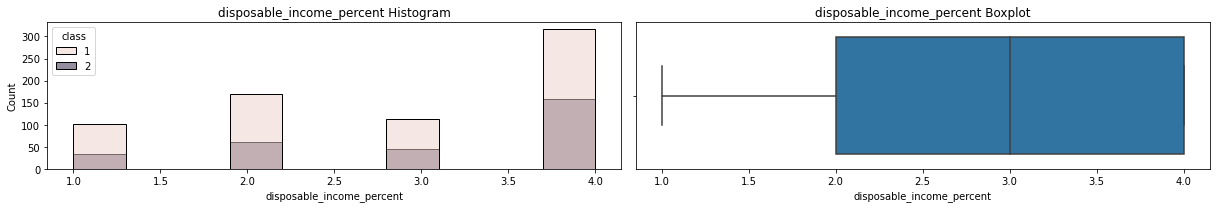

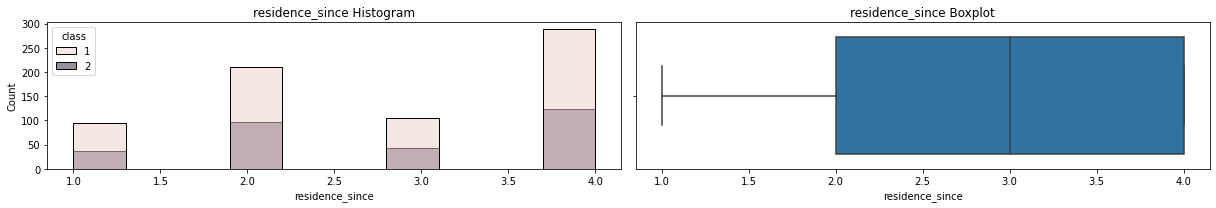

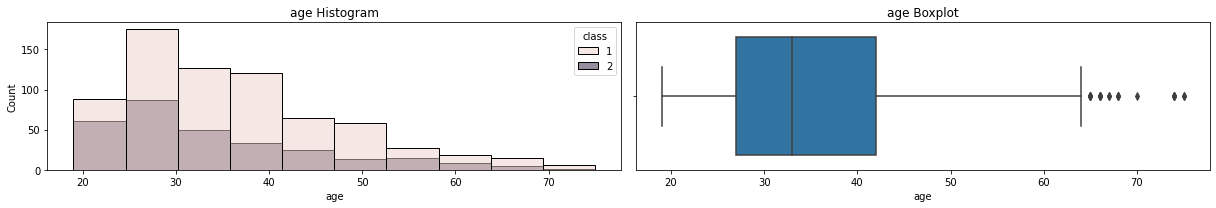

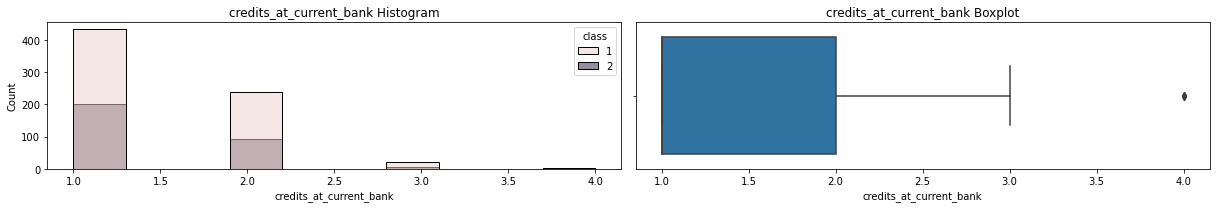

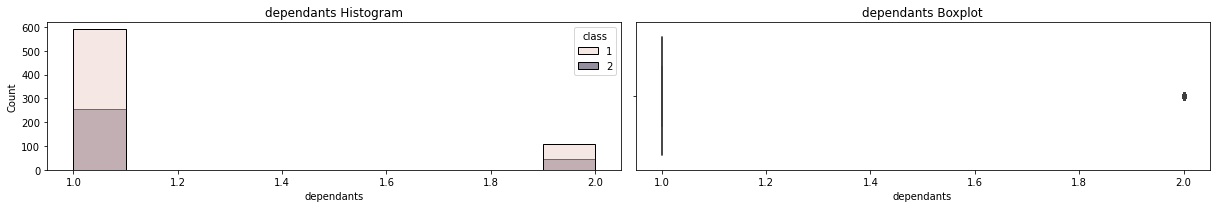

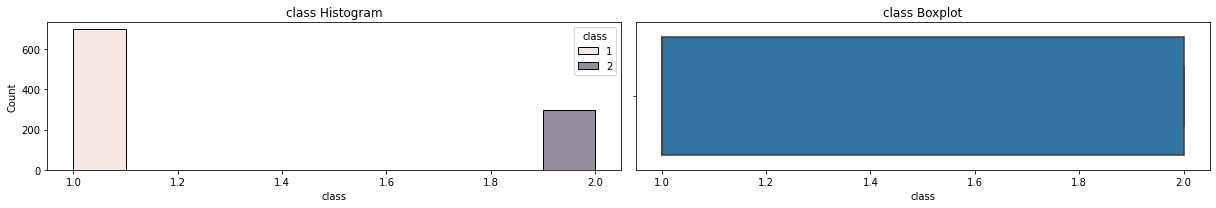

In [58]:
for i in df.columns:
    if df[i].dtype == 'int64':
        fig, ax = plt.subplots(1, 2, figsize=(17, 3))

        sns.histplot(data=df, x=i, bins=10, ax=ax[0], hue='class')
        ax[0].set_title(f'{i} Histogram')
      

        sns.boxplot(data=df, x=i, ax=ax[1])
        ax[1].set_title(f'{i} Boxplot')
   
        plt.tight_layout()
        plt.show();

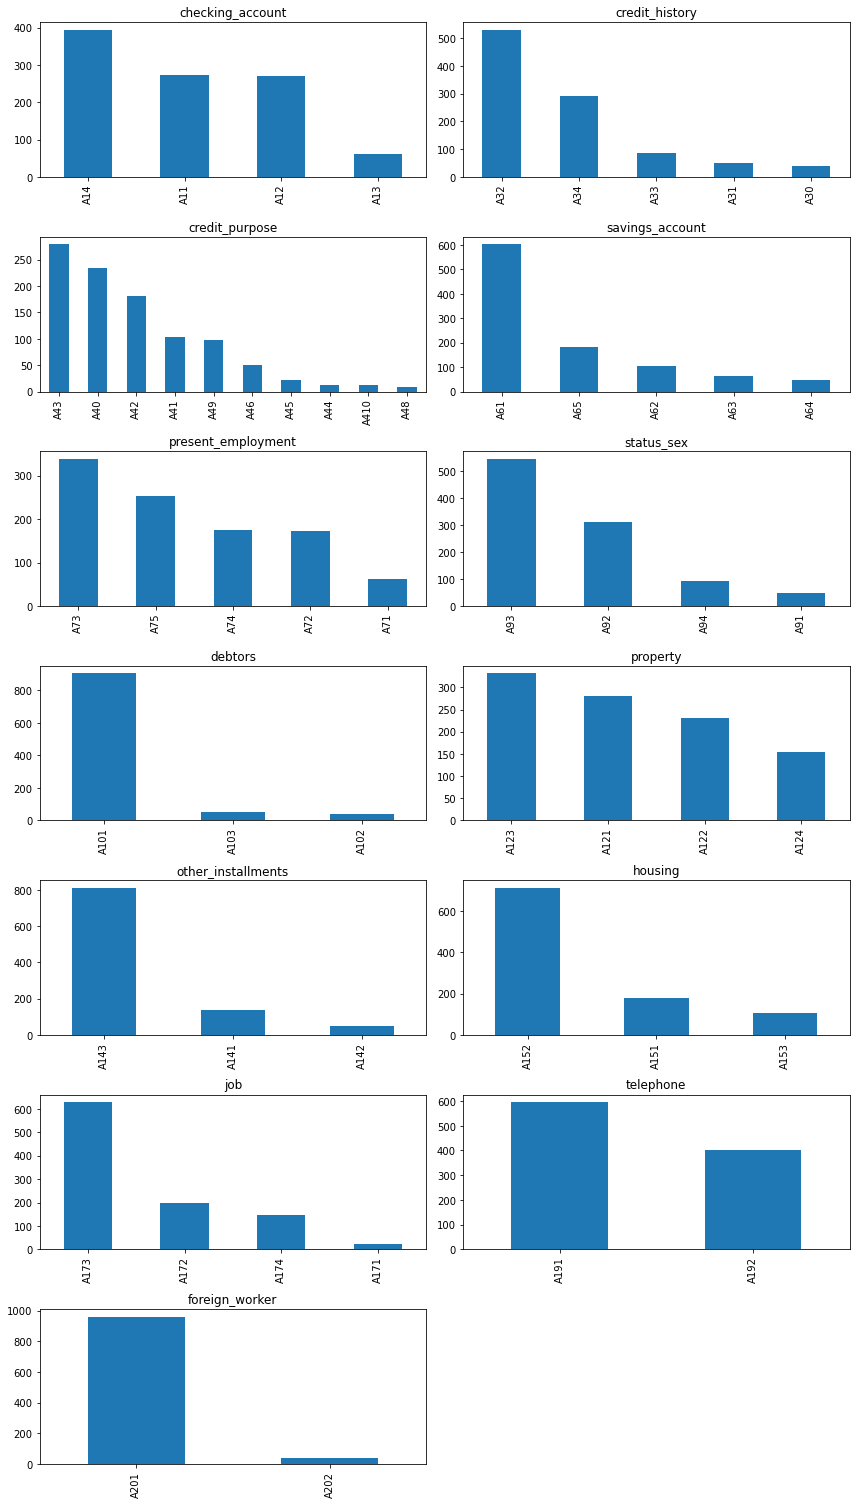

In [70]:
object_columns = df.select_dtypes(include='object').columns

num_rows = (len(object_columns) + 1) // 2  

fig, axes = plt.subplots(num_rows, 2, figsize=(12, 3*num_rows))

axes = axes.flatten()

for i, col in enumerate(object_columns):
    df[col].value_counts().plot(kind='bar', ax=axes[i],)
    axes[i].set_title(col)

for i in range(len(object_columns), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

<AxesSubplot:>

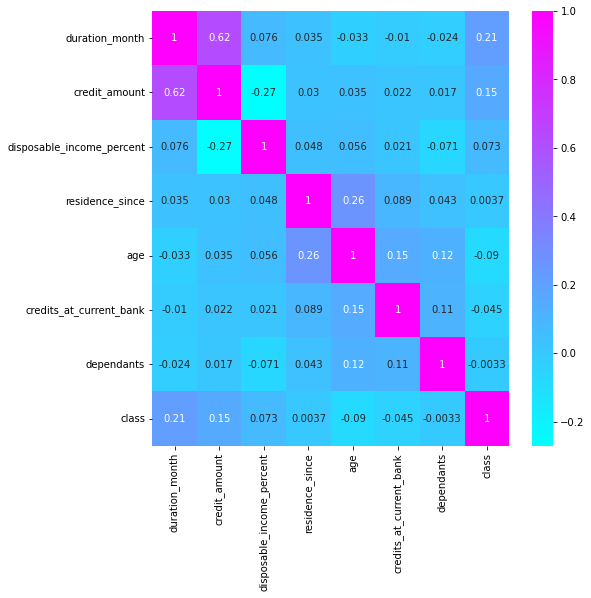

In [15]:
corr_matr = df.corr()
plt.figure(figsize=(8,8))
sns.heatmap(corr_matr, cmap= 'cool', annot= True)

### Analayzing Good vs Bad Credit

In [18]:
bad_credit = df[df['class'] == 2]
good_credit = df[df['class'] == 1]

In [35]:
bad_credit.groupby('credits_at_current_bank').mean()

,duration_month,credit_amount,disposable_income_percent,residence_since,age,dependants,class
credits_at_current_bank,,,,,,,
1,24.335000,3751.870000,3.150000,2.770000,33.250000,1.135000,2.0
2,26.076087,4313.076087,3.032609,2.956522,35.054348,1.184783,2.0
3,24.000000,4204.000000,2.333333,3.500000,40.833333,1.333333,2.0
4,24.000000,4518.500000,3.000000,4.000000,34.500000,1.000000,2.0


In [36]:
good_credit.groupby('credits_at_current_bank').mean()

,duration_month,credit_amount,disposable_income_percent,residence_since,age,dependants,class
credits_at_current_bank,,,,,,,
1,19.166282,2963.034642,2.856813,2.806005,35.247113,1.129330,1.0
2,19.858333,3043.820833,3.029167,2.850000,36.716667,1.179167,1.0
3,13.454545,3008.772727,2.727273,3.272727,45.545455,1.363636,1.0
4,19.500000,2236.750000,4.000000,3.750000,53.500000,1.500000,1.0


***Observations:***
- The **average credit amount** in people with bad credit tends to me more in general in comparison to people with good credit. In other words, bad credit has more accounts open and ask for more money
- The **average age** of people with 4 or more credit accounts in the current bank is 53 years old with good credit and 34.5 years old with bad credit 


   Status of existing checking account
        
        A11 :      ... <    0 DM
	    
        A12 : 0 <= ... <  200 DM
	    
        A13 :      ... >= 200 DM /
		
        salary assignments for at least 1 year
        
        A14 : no checking account

In [43]:
print(f'Good credit:\n{good_credit.checking_account.value_counts()}')
print(f'Bad Credit:\n{bad_credit.checking_account.value_counts()}')

Good credit:
A14    348
A12    164
A11    138
A13     49
Name: checking_account, dtype: int64
Bad Credit:
A11    135
A12    105
A14     46
A13     14
Name: checking_account, dtype: int64


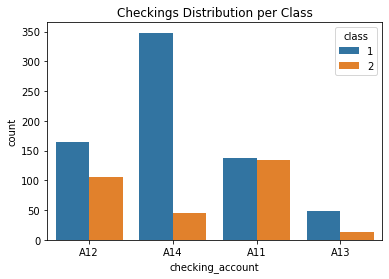

In [74]:
sns.countplot(x='checking_account', data=df, hue='class')
plt.title('Checkings Distribution per Class')
plt.show();

***Observations:***
- People with good credit do not have checking account at the current bank, while people wioth bad credit have more accoutns open
- For the people that do have an account open, people with good credit have more than 200 DM in their account

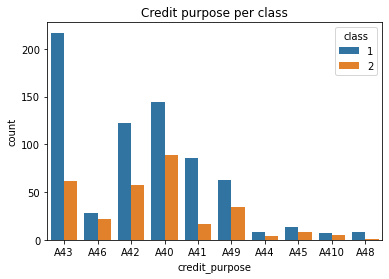

In [81]:
sns.countplot(x ='credit_purpose',hue='class', data= df)
plt.title('Credit purpose per class')
plt.show();

Attribute 4:  (qualitative)
	      Purpose
	      A40 : car (new)
	      A41 : car (used)
	      A42 : furniture/equipment
	      A43 : radio/television
	      A44 : domestic appliances
	      A45 : repairs
	      A46 : education
	      A47 : (vacation - does not exist?)
	      A48 : retraining
	      A49 : business
	      A410 : others


***Observations:***
- Class 1(good) use their credit for radio and televisions, while people with bad credit tend to use their credit mostly for purchasing a car. Another interesiting fact is that people with good credit tend to use their credit for business purposes.

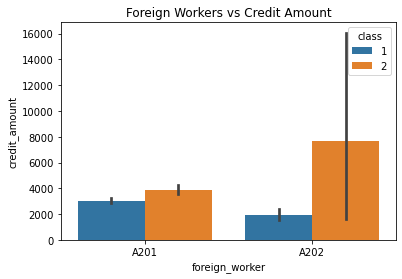

In [92]:
sns.barplot(x = 'foreign_worker', y ='credit_amount', data = df,  hue='class')
plt.title('Foreign Workers vs Credit Amount')
plt.show()

foreign worker:

A201 : yes

A202 : no

***Observations:***
- Foreign workers, tend to ask higher amnounts of credit and tend to have a population with higher bad credit history